# Setting up program

## Imports

In [6]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import math
import pandas as pd
import pickle

import config
from config import BasePaths
from CellLineWork.CellLineExpressionMatrix import CellLineExpressionMatrix

## Upload preprocessed matrix
1. Normalize read counts per cell (divide by sum of reads in cell)
2. Change to TPM values (x10^6)
3. Filter cells (>4000 non zero genes)
4. Filter genes (log2(mean(TPM)+1)>=3
5. Transform values to log TMP by log2((TPM/10)+1)
6. Center values per gene

In [7]:
exp_obj = CellLineExpressionMatrix().execute()

# Separating to cell lines

# Clustering

In [8]:
def create_clustering(expression_mat, show=False, p=100):
    # Create correlation based distance matrix
    corr_dist_matrix = scipy.spatial.distance.cdist(expression_mat.transpose(), 
                                                    expression_mat.transpose(), 'correlation')
    corr_dist_condensed = scipy.spatial.distance.pdist(expression_mat.transpose(), metric='correlation')
    
    print(corr_dist_matrix.shape, len(corr_dist_condensed), 
          expression_mat.shape, expression_mat.shape[1]*(expression_mat.shape[1]-1)/2)
    # Create tree
    corr_tree = linkage(corr_dist_condensed, method='average')

    # Create dendrogram
    corr_dn = dendrogram(corr_tree)
    
    if show:
        fig, ax = plt.subplots()
        ax.set_title('Hierarchical Clustering Dendrogram (truncated)')
        ax.set_xlabel('sample index')
        ax.set_ylabel('distance')
        dendrogram(
            corr_tree,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            ax=ax
        )
        plt.show()
    return corr_dist_matrix, corr_tree, corr_dn

In [9]:
def show_correlation_heatmap(expression_matrix, dendogram, corr_matrix=None, vmax=None, vmin=None):
    plt.subplot()
    if corr_matrix is None:
        corr_matrix = np.corrcoef(expression_matrix.iloc[:, dendogram['leaves']].transpose())
        mask = corr_matrix==1
        if vmin is None:
            vmin = -max(np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 95)), 
                        np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 0.05)))
        if vmax is None:
            vmax = max(np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 95)), 
                        np.absolute(np.percentile(corr_matrix[corr_matrix!=1], 0.05)))
        print('vmax={}, vmin={}'.format(vmax, vmin))
        sns.heatmap(corr_matrix, xticklabels=False, yticklabels=False, cmap='seismic', vmax=vmax, vmin=vmin)
        print(corr_matrix.shape)
    else:
        sns.heatmap(pd.DataFrame(corr_matrix).iloc[dendogram['leaves'], dendogram['leaves']], 
                xticklabels=False, yticklabels=False, cmap='seismic', vmin=-1, vmax=1)
    plt.show()

(2635, 2635) 3470295 (9125, 2635) 3470295.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


vmax=0.18085199910257074, vmin=-0.18085199910257074
(2635, 2635)


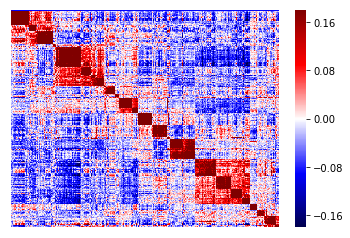

In [10]:
full_dist, full_tree, full_dn = create_clustering(exp_obj.expression_matrix, show=False)
show_correlation_heatmap(exp_obj.expression_matrix, full_dn)

vmax=0.3, vmin=-0.3
(2635, 2635)


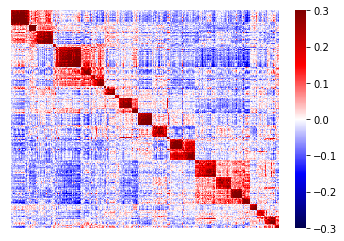

In [11]:
show_correlation_heatmap(exp_obj.expression_matrix, full_dn, vmin=-0.3, vmax=0.3)

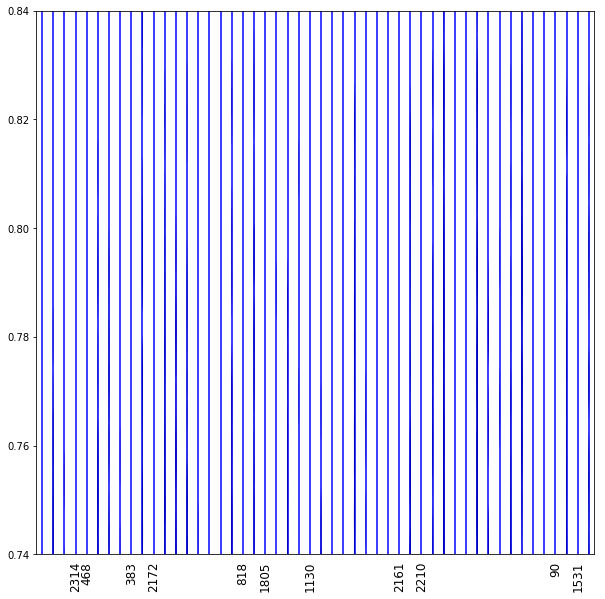

In [12]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
dendrogram(
            full_tree,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=50,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches,
            ax=ax
        )
ax.set_ylim(bottom=0.74, top=0.84)
plt.show()

# Separate to cell lines

In [13]:
cell_lines_path = BasePaths.CellLineExpression
columns_to_compare=['GE_CCLE_match', 'SNP_CL_match']
cell_id_column="sample_id"

In [14]:
def get_cohesive_cell_lines(csv_path, columns_to_compare, id_column):
    cell_lines = pd.read_csv(csv_path)
    cohesive_cells_lines = cell_lines.loc[
        cell_lines.apply(lambda x: len(np.unique(x[columns_to_compare])) == 1, axis=1)]
    return cohesive_cells_lines[[id_column, columns_to_compare[0]]].rename(
        columns={columns_to_compare[0]: "CellLine"})

In [15]:
cohesive_cell_lines = get_cohesive_cell_lines(cell_lines_path, columns_to_compare, cell_id_column)
cell_lines = set(cohesive_cell_lines['CellLine'].values)
cohesive_cell_lines.groupby('CellLine').count().sort_values(by='sample_id', ascending=False)

sample_id
CellLine                                    
TE14_OESOPHAGUS                          225
8305C_THYROID                            185
OVCAR4_OVARY                             149
ONCODG1_OVARY                            146
CAKI2_KIDNEY                             138
NCIH2228_LUNG                            130
SNU46_UPPER_AERODIGESTIVE_TRACT          125
KALS1_CENTRAL_NERVOUS_SYSTEM             115
SKMEL5_SKIN                              103
U118MG_CENTRAL_NERVOUS_SYSTEM            102
UACC257_SKIN                             100
ASPC1_PANCREAS                            97
SCC25_UPPER_AERODIGESTIVE_TRACT           88
BICR16_UPPER_AERODIGESTIVE_TRACT          87
NCIH2444_LUNG                             79
HUH28_BILIARY_TRACT                       76
OAW28_OVARY                               72
HEC6_ENDOMETRIUM                          65
IM95_STOMACH                              44
HCC366_LUNG                               39
NCIH2073_LUNG                             36
SNU1214_UPPER_AERODIGESTIVE_TRACT         30
TE10_OESOPHAGUS                           26
SU8686_PANCREAS                           17

In [44]:
def get_cohesive_expression_obj(exp_obj, cohesive_cell_lines):
#     cohesive_cell_indices = list(map(lambda x: x in cohesive_cell_lines.sample_id.values, exp_obj.cells_matrix))
# #     cohesive_cell_indices = [c[0] for c in enumerate(cohesive_cell_indices) if c[1]]
#     return cohesive_cell_indices
#     cohesive_exp_matrix = exp_obj.expression_matrix.loc[:, cohesive_cell_indices]
#     print(cohesive_exp_matrix.shape, exp_obj.expression_matrix.shape)
    return exp_obj.expression_matrix.loc[:, cohesive_cell_lines.sample_id.values]

In [49]:
cohesive_exp_matrix = get_cohesive_expression_obj(exp_obj, cohesive_cell_lines).transpose()
cohesive_exp_matrix['CellLine'] = cohesive_cell_lines.set_index('sample_id').loc[cohesive_exp_matrix.index]
cohesive_exp_matrix.head()

ENSG00000239945  RP5-857K21.1  RP5-857K21.4  RP5-857K21.5  \
AAACCTGCAAACGTGG-1         1.150069     -0.612891     -0.517273      0.898029   
AAACCTGGTAAATACG-1        -1.617814     -0.612891     -0.517273      1.010792   
AAACCTGGTTAAGTAG-1        -1.617814      1.087895      2.805106     -0.300016   
AAACCTGTCAATCTCT-1         0.767870     -0.612891     -0.517273     -0.374173   
AAACCTGTCTTATCTG-1        -1.617814     -0.612891     -0.517273     -0.099966   

                    ENSG00000240618  ENSG00000229905  RP11-206L10.4  \
AAACCTGCAAACGTGG-1        -0.211171         1.664156       0.214821   
AAACCTGGTAAATACG-1        -1.672097        -1.074126      -1.750702   
AAACCTGGTTAAGTAG-1         0.123544        -1.522396      -0.049915   
AAACCTGTCAATCTCT-1         0.831501        -1.969217      -1.750702   
AAACCTGTCTTATCTG-1        -0.831734         0.412197       1.790282   

                    ENSG00000237491  LINC00115  ENSG00000230368  \
AAACCTGCAAACGTGG-1        -0.645481  -0.251104         1.257913   
AAACCTGGTAAATACG-1         1.174049   0.316563         0.576614   
AAACCTGGTTAAGTAG-1         1.055306   0.500878        -2.022542   
AAACCTGTCAATCTCT-1         1.740204   0.414136         1.218053   
AAACCTGTCTTATCTG-1         1.226335   0.568649         0.637350   

                                 ...                      IDS  FAM47E-STBD1  \
AAACCTGCAAACGTGG-1               ...                 0.633275      0.495997   
AAACCTGGTAAATACG-1               ...                 0.991346      0.830600   
AAACCTGGTTAAGTAG-1               ...                -0.069979     -0.571100   
AAACCTGTCAATCTCT-1               ...                 1.137571      0.603672   
AAACCTGTCTTATCTG-1               ...                 0.516371     -2.271887   

                        TLR9      TAP2     DCAF8     SOGA3     EFNA3  \
AAACCTGCAAACGTGG-1  0.470030 -0.579032  0.893903  0.979992  1.543414   
AAACCTGGTAAATACG-1 -0.990896  1.240497 -1.873981  1.470186  0.595059   
AAACCTGGTTAAGTAG-1  1.876557 -0.579032 -1.873981 -0.599677 -1.224470   
AAACCTGTCAATCTCT-1 -0.424741 -0.579032 -1.873981  0.575096 -1.224470   
AAACCTGTCTTATCTG-1 -2.810425 -0.579032  0.785911  0.359428  1.435422   

                      CRYBG3     PSMA2                         CellLine  
AAACCTGCAAACGTGG-1  1.390680 -0.743895  SCC25_UPPER_AERODIGESTIVE_TRACT  
AAACCTGGTAAATACG-1  1.244687 -0.743895    U118MG_CENTRAL_NERVOUS_SYSTEM  
AAACCTGGTTAAGTAG-1 -0.574842  1.715947                  TE14_OESOPHAGUS  
AAACCTGTCAATCTCT-1 -0.574842 -0.743895    U118MG_CENTRAL_NERVOUS_SYSTEM  
AAACCTGTCTTATCTG-1 -0.574842 -0.743895              HUH28_BILIARY_TRACT  

[5 rows x 9126 columns]

In [50]:
cell_lines_dict = {}
for cell_line in set(cohesive_exp_matrix.CellLine.values):
    exp_mat = cohesive_exp_matrix.loc[
        cohesive_exp_matrix.CellLine==cell_line,
        [col for col in cohesive_exp_matrix.columns if col!='CellLine']].transpose()
    if exp_mat.shape[1]>=50:
        cell_lines_dict[cell_line] = exp_mat

## Cluster each cell line

working on SNU46_UPPER_AERODIGESTIVE_TRACT
(125, 125) 7750 (9125, 125) 7750.0


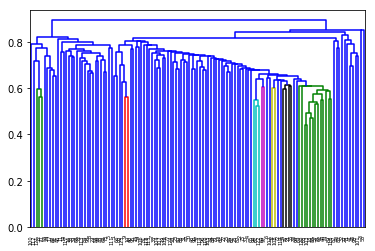

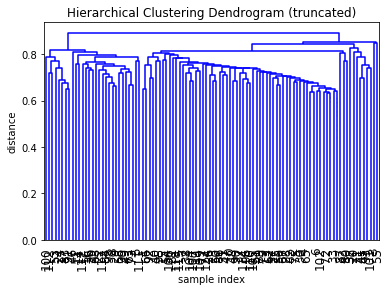

vmax=0.3431673948823909, vmin=0.0
(125, 125)


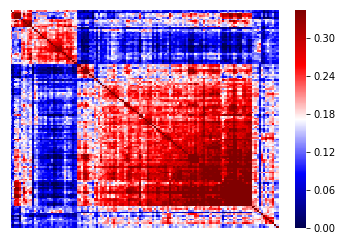

working on NCIH2228_LUNG
(130, 130) 8385 (9125, 130) 8385.0


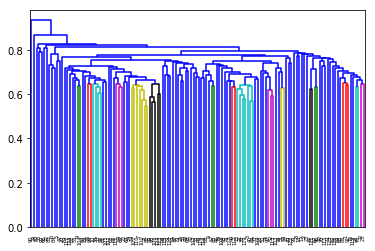

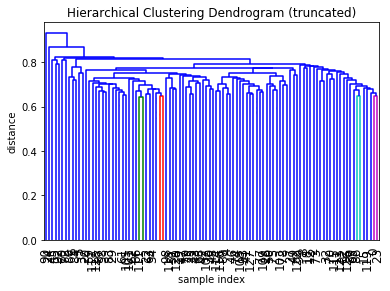

vmax=0.3215563371185294, vmin=0.0
(130, 130)


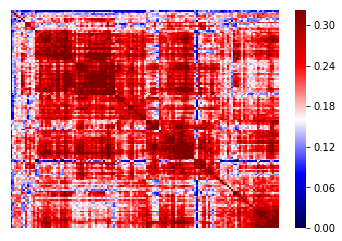

working on SKMEL5_SKIN
(103, 103) 5253 (9125, 103) 5253.0


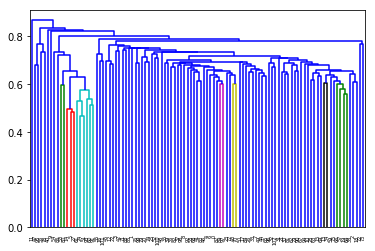

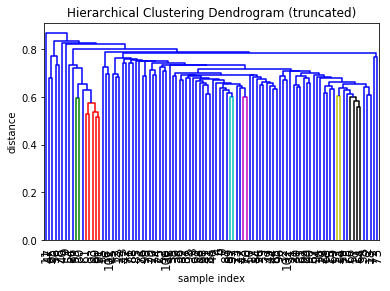

vmax=0.3434176274955878, vmin=0.0
(103, 103)


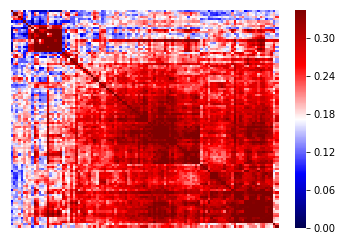

working on SCC25_UPPER_AERODIGESTIVE_TRACT
(88, 88) 3828 (9125, 88) 3828.0


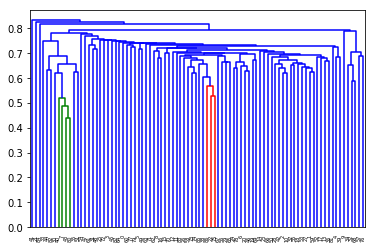

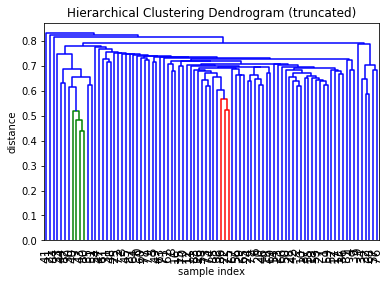

vmax=0.3336835784349789, vmin=0.0
(88, 88)


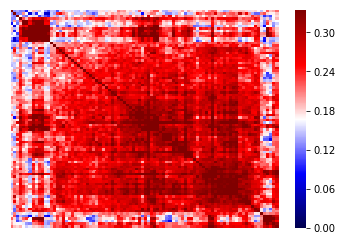

working on KALS1_CENTRAL_NERVOUS_SYSTEM
(115, 115) 6555 (9125, 115) 6555.0


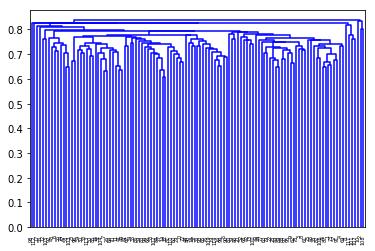

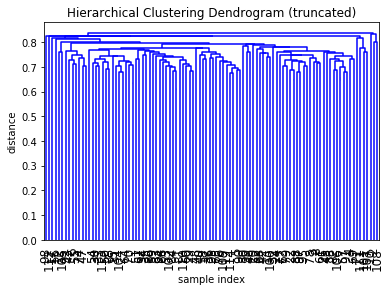

vmax=0.2823596363214566, vmin=0.0
(115, 115)


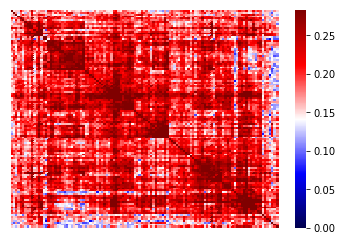

working on U118MG_CENTRAL_NERVOUS_SYSTEM
(102, 102) 5151 (9125, 102) 5151.0


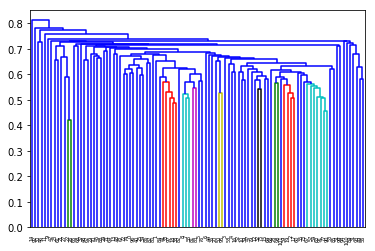

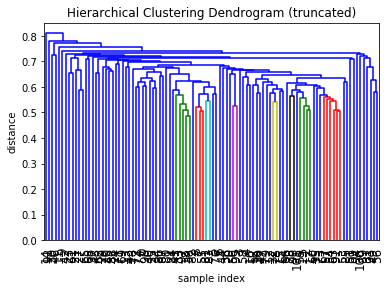

vmax=0.4037732952867593, vmin=0.0
(102, 102)


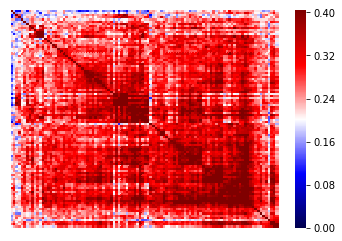

working on CAKI2_KIDNEY
(138, 138) 9453 (9125, 138) 9453.0


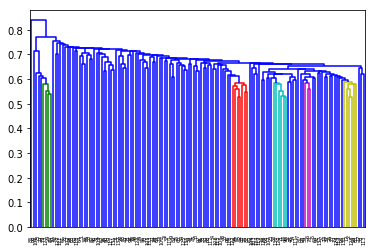

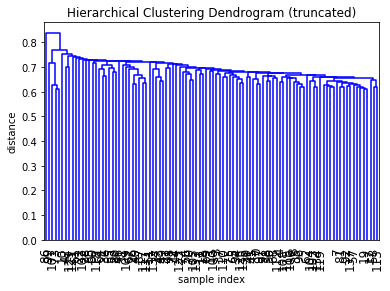

vmax=0.3827351906142955, vmin=0.0
(138, 138)


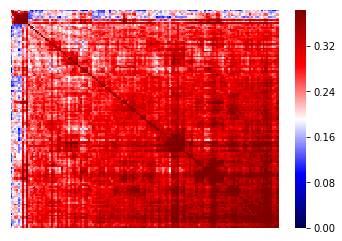

working on OVCAR4_OVARY
(149, 149) 11026 (9125, 149) 11026.0


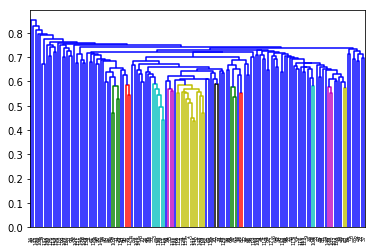

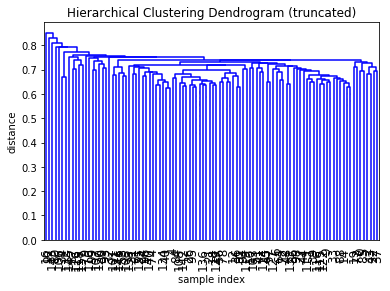

vmax=0.38014820142342876, vmin=0.0
(149, 149)


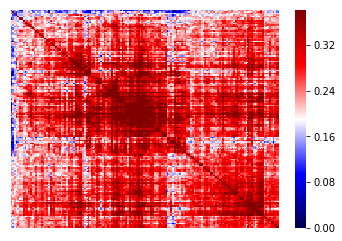

working on HUH28_BILIARY_TRACT
(76, 76) 2850 (9125, 76) 2850.0


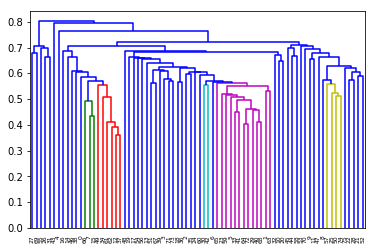

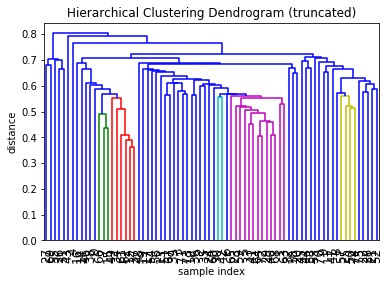

vmax=0.4515366765566351, vmin=0.0
(76, 76)


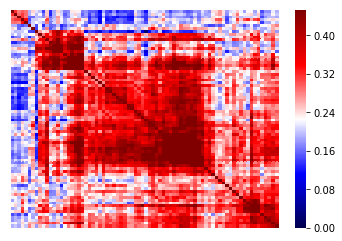

working on BICR16_UPPER_AERODIGESTIVE_TRACT
(87, 87) 3741 (9125, 87) 3741.0


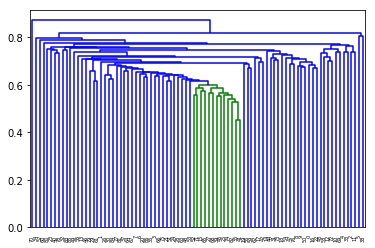

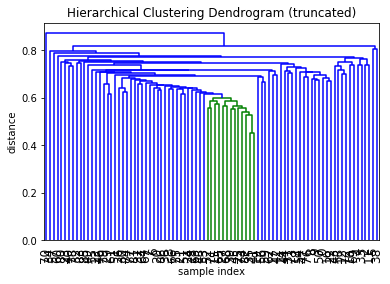

vmax=0.37621657603767183, vmin=0.0
(87, 87)


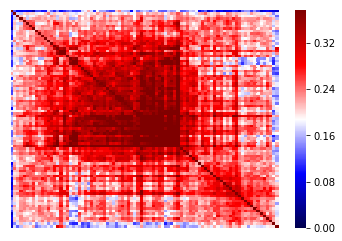

working on OAW28_OVARY
(72, 72) 2556 (9125, 72) 2556.0


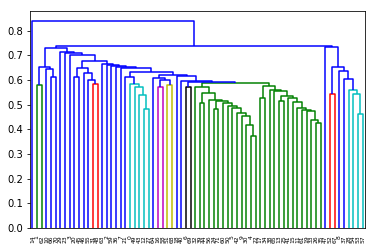

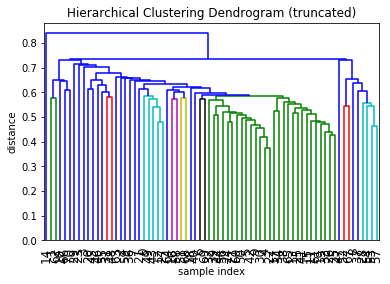

vmax=0.4759972481686045, vmin=0.0
(72, 72)


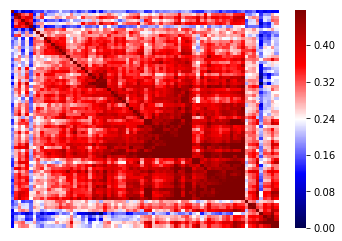

working on UACC257_SKIN
(100, 100) 4950 (9125, 100) 4950.0


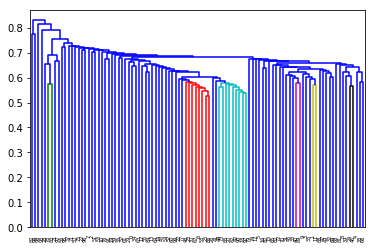

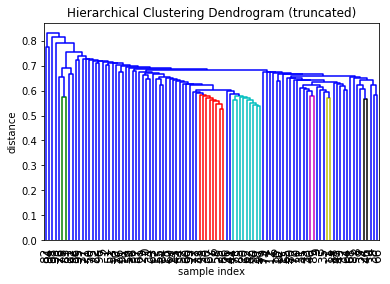

vmax=0.3924276534277922, vmin=0.0
(100, 100)


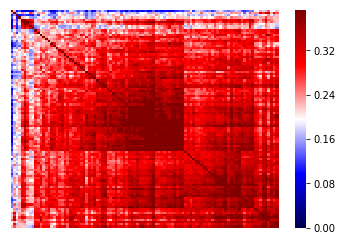

working on ONCODG1_OVARY
(146, 146) 10585 (9125, 146) 10585.0


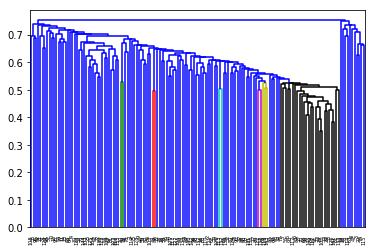

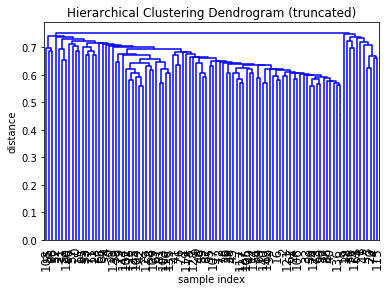

vmax=0.4623106091921334, vmin=0.0
(146, 146)


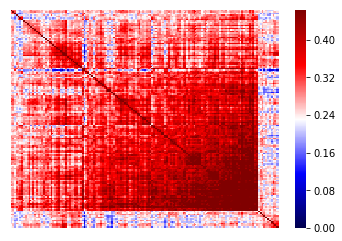

working on ASPC1_PANCREAS
(97, 97) 4656 (9125, 97) 4656.0


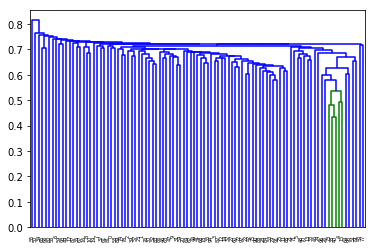

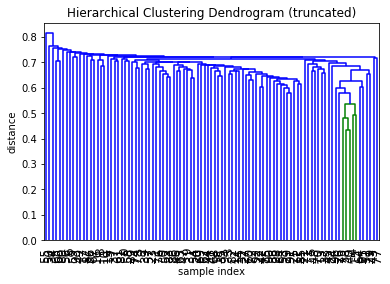

vmax=0.3535901745188974, vmin=0.0
(97, 97)


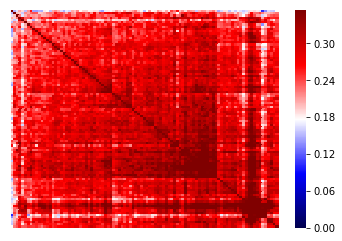

working on HEC6_ENDOMETRIUM
(65, 65) 2080 (9125, 65) 2080.0


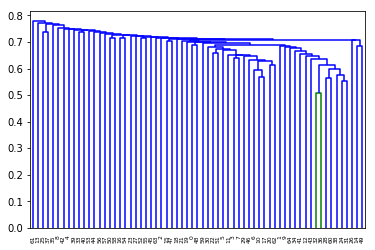

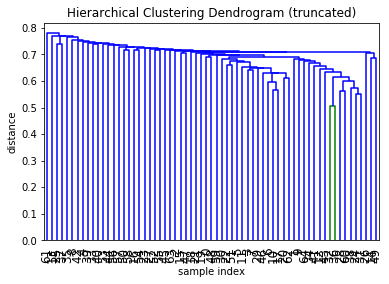

vmax=0.3536658760554445, vmin=0.0
(65, 65)


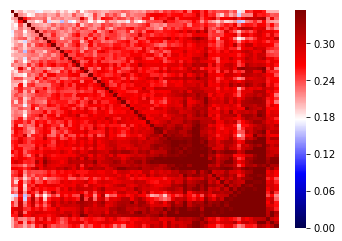

working on 8305C_THYROID
(185, 185) 17020 (9125, 185) 17020.0


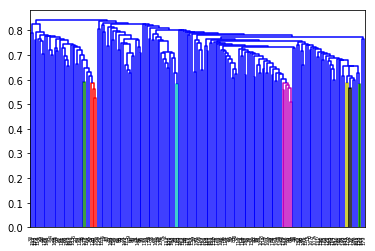

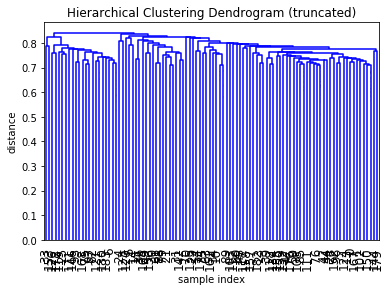

vmax=0.3070172336563103, vmin=0.0
(185, 185)


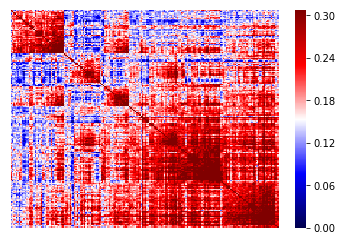

working on NCIH2444_LUNG
(79, 79) 3081 (9125, 79) 3081.0


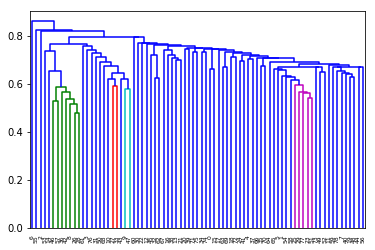

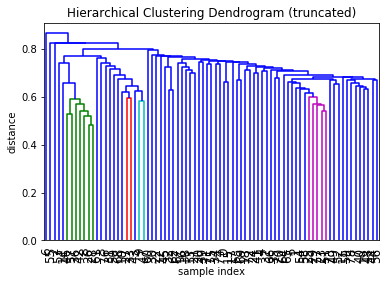

vmax=0.3411341015165188, vmin=0.0
(79, 79)


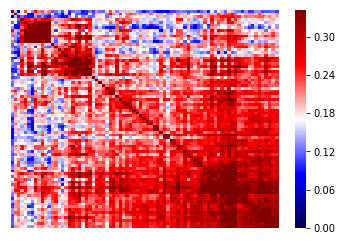

working on TE14_OESOPHAGUS
(225, 225) 25200 (9125, 225) 25200.0


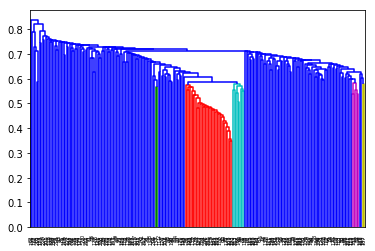

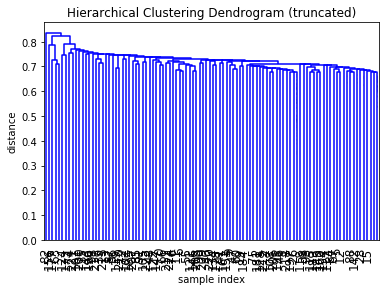

vmax=0.38715060036010274, vmin=0.0
(225, 225)


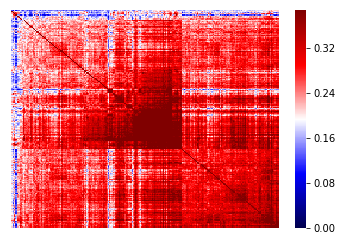

In [51]:
for cell_line, exp_matrix in cell_lines_dict.items():
    print('working on {}'.format(cell_line))
    corr_dist, tree, dn = create_clustering(exp_matrix, show=True)
    show_correlation_heatmap(exp_matrix, dn, vmin=0.0)

## Test new threshold for genes (consider 4)

In [52]:
class HasName: pass
in_path = HasName()
in_path.name = ''
for pipe_step in  exp_obj.composing_items[:2]:
    in_path.name = pipe_step.out_file_path(in_path)
print(in_path.name)
with open(in_path.name, 'rb') as in_file:
    original_exp_obj = pickle.load(in_file)
original_exp_obj

/Users/iriskalka/Dropbox (Weizmann Institute)/CacheCopy/PipelineCache/FromMatExpressionMatrix_NormalizeExpressionByCell


working on cell line SNU46_UPPER_AERODIGESTIVE_TRACT


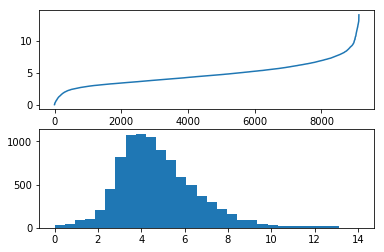

working on cell line NCIH2228_LUNG


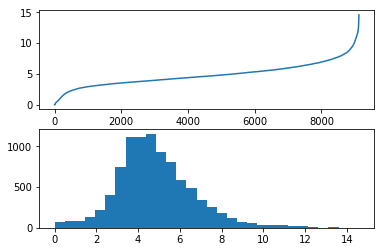

working on cell line SKMEL5_SKIN


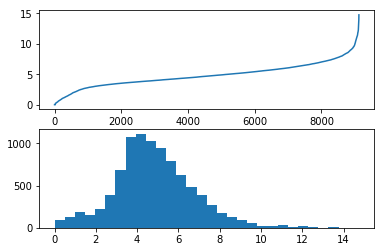

working on cell line SCC25_UPPER_AERODIGESTIVE_TRACT


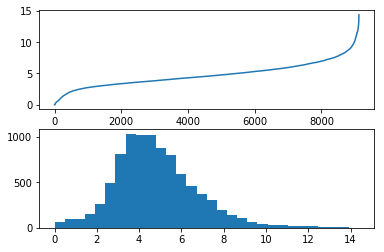

working on cell line KALS1_CENTRAL_NERVOUS_SYSTEM


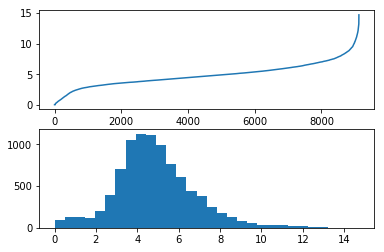

working on cell line U118MG_CENTRAL_NERVOUS_SYSTEM


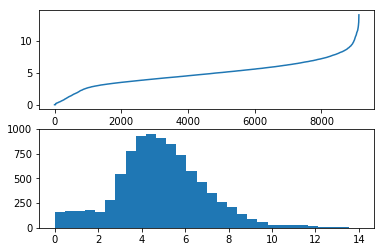

working on cell line CAKI2_KIDNEY


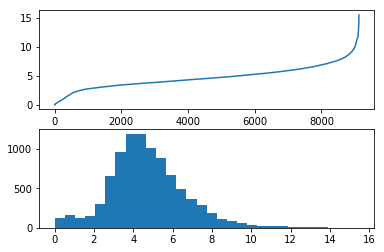

working on cell line OVCAR4_OVARY


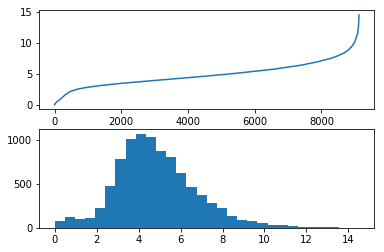

working on cell line HUH28_BILIARY_TRACT


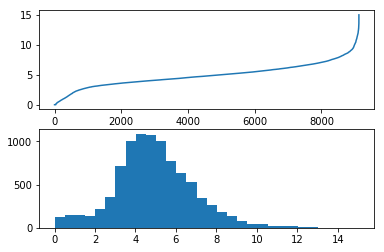

working on cell line BICR16_UPPER_AERODIGESTIVE_TRACT


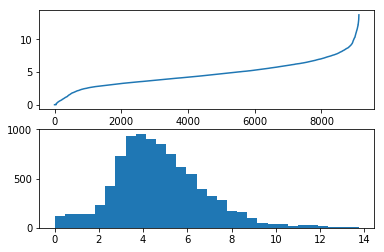

working on cell line OAW28_OVARY


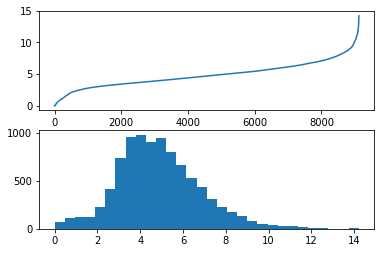

working on cell line UACC257_SKIN


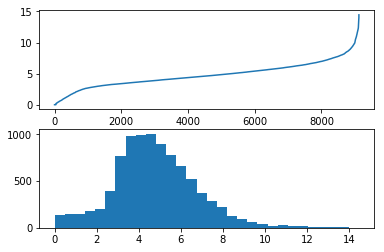

working on cell line ONCODG1_OVARY


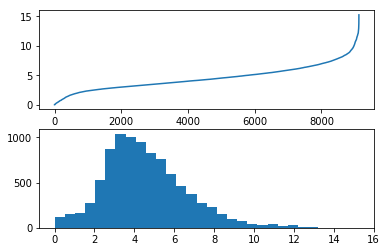

working on cell line ASPC1_PANCREAS


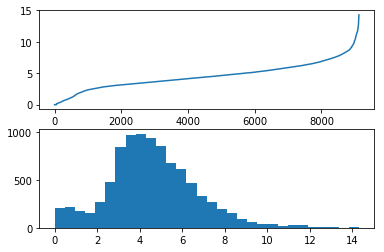

working on cell line HEC6_ENDOMETRIUM


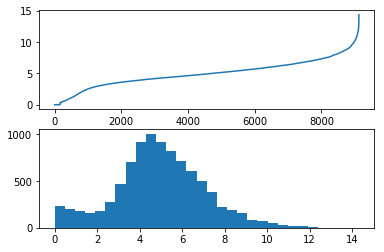

working on cell line 8305C_THYROID


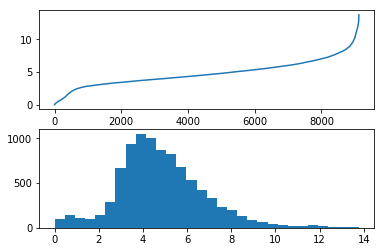

working on cell line NCIH2444_LUNG


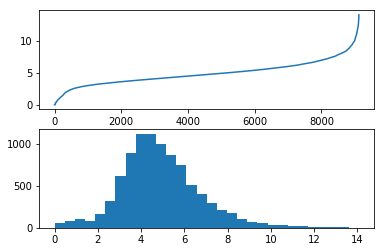

working on cell line TE14_OESOPHAGUS


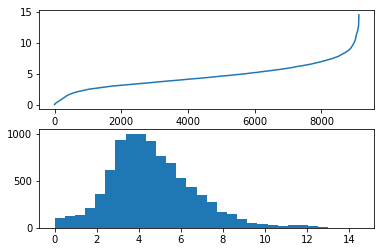

In [57]:
tmp_dict = {}
for cell_line, exp_matrix in cell_lines_dict.items():
    print("working on cell line {}".format(cell_line))
    tmp_original_exp = original_exp_obj.expression_matrix.loc[exp_matrix.index, exp_matrix.columns]
    gene_sum_values = tmp_original_exp.values
    gene_sum_values = gene_sum_values.mean(axis=1)
    gene_sum_values += 1
    gene_sum_values = np.log2(gene_sum_values)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(range(len(gene_sum_values)), np.sort(gene_sum_values))
    ax[1].hist(gene_sum_values, bins=30)
    plt.show()
    tmp_dict[cell_line] = exp_matrix.iloc[gene_sum_values>4, :]
cell_lines_dict = tmp_dict

In [58]:
cell_line_name = 'ONCODG1_OVARY'
single_cell_line_exp = cell_lines_dict[cell_line_name]
single_cell_line_exp.head()

AAACGGGCAGGACCCT-1  AAACGGGGTGCGCTTG-1  AAAGCAATCCTTGGTC-1  \
RP5-857K21.5               0.966179            0.827275            1.444698   
ENSG00000240618           -0.932603           -1.987593           -0.210870   
ENSG00000229905           -1.784793           -2.142332           -0.429050   
RP11-206L10.4              0.808322            1.310276            1.731083   
ENSG00000237491            1.139670            0.858552            1.320291   

                 AAAGTAGTCGGCGCAT-1  AACTCCCAGGTGGGTT-1  AACTCTTGTCCGACGT-1  \
RP5-857K21.5               0.829589            0.029701            0.074532   
ENSG00000240618            2.148755           -0.702067           -0.057083   
ENSG00000229905           -0.221174            2.253533           -0.316412   
RP11-206L10.4              1.636191            0.233739           -1.750702   
ENSG00000237491            1.408857           -0.645481            0.509286   

                 AAGACCTAGATGCCAG-1  ACACCCTGTTGGTTTG-1  ACATACGGTGACGGTA-1  \
RP5-857K21.5              -1.101448            0.518789           -1.013906   
ENSG00000240618            0.417037            1.148604           -0.110808   
ENSG00000229905            0.390324           -1.932444            0.337614   
RP11-206L10.4              1.150416            0.341563            0.762365   
ENSG00000237491            2.030721           -0.645481            1.867586   

                 ACATCAGGTTGATTCG-1         ...          TGTCCCAAGAACTGTA-1  \
RP5-857K21.5               0.435348         ...                    0.314207   
ENSG00000240618            1.893650         ...                    1.828948   
ENSG00000229905           -1.359494         ...                   -1.770711   
RP11-206L10.4              0.593999         ...                    1.323363   
ENSG00000237491            0.958484         ...                    0.868190   

                 TGTCCCACATCATCCC-1  TGTCCCATCAACCATG-1  TTAACTCTCTTGTCAT-1  \
RP5-857K21.5               0.473129            0.537795            1.947978   
ENSG00000240618           -1.112819            0.980832            1.930923   
ENSG00000229905           -1.976564           -1.547123            2.061704   
RP11-206L10.4              1.117510            0.904624            0.840673   
ENSG00000237491            1.733326            0.822648           -0.645481   

                 TTAGGACCACACATGT-1  TTAGGACCATTACCTT-1  TTAGGCAGTCCAAGTT-1  \
RP5-857K21.5               1.196200            0.045039            1.381143   
ENSG00000240618            1.482118            1.695409           -1.482298   
ENSG00000229905           -0.497109           -0.638035           -0.585075   
RP11-206L10.4             -0.992459            0.416993            1.067309   
ENSG00000237491            0.112762            1.159826            0.683915   

                 TTCGGTCCAGTATGCT-1  TTGGCAATCGTACGGC-1  TTGTAGGTCTATCCTA-1  
RP5-857K21.5               0.601393           -0.392924            0.113426  
ENSG00000240618           -0.560711            3.981946           -0.969197  
ENSG00000229905           -1.483525           -0.267565           -0.915321  
RP11-206L10.4              0.117343            1.104821            0.771727  
ENSG00000237491           -0.645481            1.721453            0.195216  

[5 rows x 146 columns]

In [59]:
# Change from log2((TPM/10)+1) to TPM
tpm_data = single_cell_line_exp.copy()
tpm_data = tpm_data.apply(lambda x: 10*((2**x)-1))
tpm_data.head()

AAACGGGCAGGACCCT-1  AAACGGGGTGCGCTTG-1  AAAGCAATCCTTGGTC-1  \
RP5-857K21.5               9.536600            7.743314           17.220575   
ENSG00000240618           -4.760876           -7.478407           -1.359840   
ENSG00000229905           -7.097823           -7.734867           -2.572493   
RP11-206L10.4              7.511732           14.798900           23.197686   
ENSG00000237491           12.033054            8.132181           14.971654   

                 AAAGTAGTCGGCGCAT-1  AACTCCCAGGTGGGTT-1  AACTCTTGTCCGACGT-1  \
RP5-857K21.5               7.771784            0.208008            0.530194   
ENSG00000240618           34.344502           -3.853090           -0.387946   
ENSG00000229905           -1.421329           37.684908           -1.969354   
RP11-206L10.4             21.084397            1.758787           -7.028428   
ENSG00000237491           16.552677           -3.607202            4.233452   

                 AAGACCTAGATGCCAG-1  ACACCCTGTTGGTTTG-1  ACATACGGTGACGGTA-1  \
RP5-857K21.5              -5.339516            4.327519           -5.047964   
ENSG00000240618            3.351827           12.169928           -0.739307   
ENSG00000229905            3.106873           -7.380151            2.636653   
RP11-206L10.4             12.197791            2.671287            6.962685   
ENSG00000237491           30.860897           -3.607202           26.492136   

                 ACATCAGGTTGATTCG-1         ...          TGTCCCAAGAACTGTA-1  \
RP5-857K21.5               3.522374         ...                    2.433278   
ENSG00000240618           27.157418         ...                   25.527804   
ENSG00000229905           -6.102809         ...                   -7.069358   
RP11-206L10.4              5.094254         ...                   15.024876   
ENSG00000237491            9.432672         ...                    8.253718   

                 TGTCCCACATCATCCC-1  TGTCCCATCAACCATG-1  TTAACTCTCTTGTCAT-1  \
RP5-857K21.5               3.881170            4.517516           28.583330   
ENSG00000240618           -5.376105            9.736033           28.129897   
ENSG00000229905           -7.459057           -6.578083           31.747909   
RP11-206L10.4             11.697216            8.720565            7.908851   
ENSG00000237491           23.249346            7.686497           -3.607202   

                 TTAGGACCACACATGT-1  TTAGGACCATTACCTT-1  TTAGGCAGTCCAAGTT-1  \
RP5-857K21.5              12.913530            0.317111           16.047458   
ENSG00000240618           17.935846           22.386874           -6.420816   
ENSG00000229905           -2.914750           -3.574126           -3.333854   
RP11-206L10.4             -4.973796            3.351420           10.955216   
ENSG00000237491            0.812965           12.343053            6.064934   

                 TTCGGTCCAGTATGCT-1  TTGGCAATCGTACGGC-1  TTGTAGGTCTATCCTA-1  
RP5-857K21.5               5.171811           -2.384155            0.817943  
ENSG00000240618           -3.220320          148.010260           -4.892099  
ENSG00000229905           -6.423860           -1.692793           -4.697740  
RP11-206L10.4              0.847356           11.507215            7.073121  
ENSG00000237491           -3.607202           22.976844            1.448952  

[5 rows x 146 columns]

In [60]:
exp_obj.composing_items

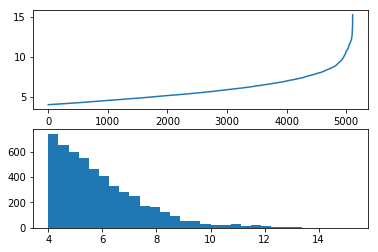

In [61]:
tmp_original_exp = original_exp_obj.expression_matrix.loc[single_cell_line_exp.index, single_cell_line_exp.columns]
gene_sum_values = tmp_original_exp.values
gene_sum_values = gene_sum_values.mean(axis=1)
gene_sum_values += 1
gene_sum_values = np.log2(gene_sum_values)
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(len(gene_sum_values)), np.sort(gene_sum_values))
ax[1].hist(gene_sum_values, bins=30)
plt.show()

<font color=red>According to these results we will add create a second threshold of 3</font>

## Recenter genes (and then re-run and save clustering)

In [62]:
centered_cell_lines_dict = {}
for cell_line, cell_line_exp in cell_lines_dict.items():
    centered_cell_lines_dict[cell_line] = {}
    centered_cell_lines_dict[cell_line]['exp_mat'] = cell_line_exp.sub(cell_line_exp.mean(axis=1), axis=0)

working on SNU46_UPPER_AERODIGESTIVE_TRACT, of shape (5726, 125)
(125, 125) 7750 (5726, 125) 7750.0


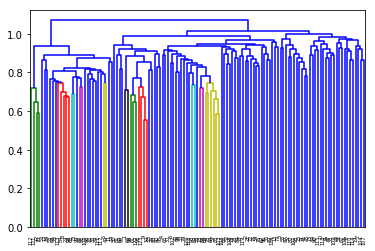

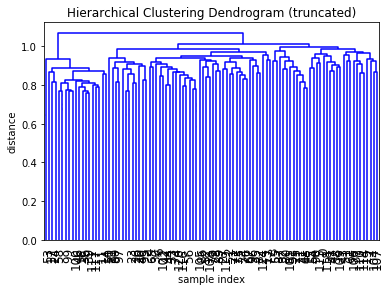

vmax=0.24997805410722304, vmin=-0.24997805410722304
(125, 125)


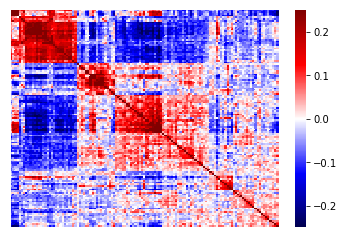

working on NCIH2228_LUNG, of shape (6021, 130)
(130, 130) 8385 (6021, 130) 8385.0


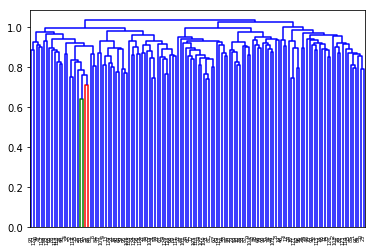

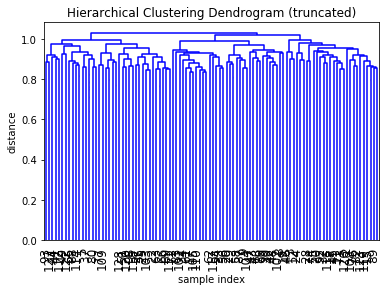

vmax=0.21478005682611656, vmin=-0.21478005682611656
(130, 130)


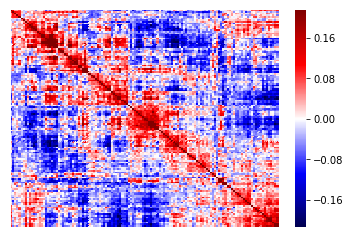

working on SKMEL5_SKIN, of shape (6059, 103)
(103, 103) 5253 (6059, 103) 5253.0


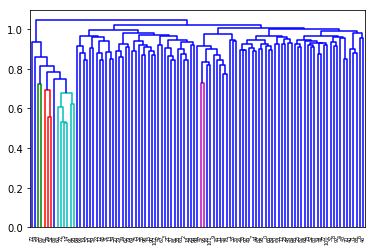

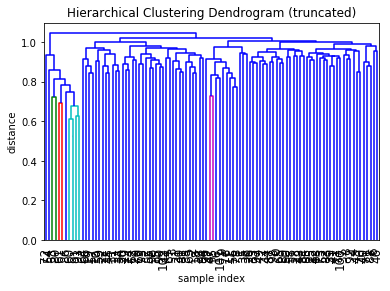

vmax=0.1765460394083067, vmin=-0.1765460394083067
(103, 103)


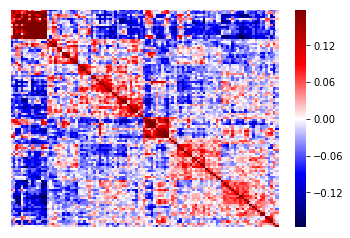

working on SCC25_UPPER_AERODIGESTIVE_TRACT, of shape (5779, 88)
(88, 88) 3828 (5779, 88) 3828.0


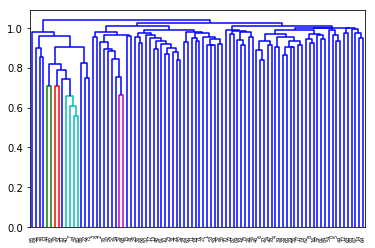

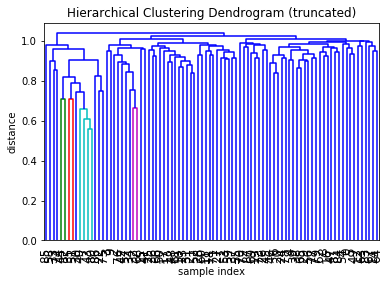

vmax=0.19510878566701503, vmin=-0.19510878566701503
(88, 88)


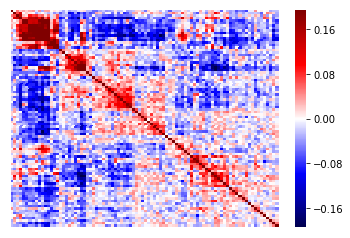

working on KALS1_CENTRAL_NERVOUS_SYSTEM, of shape (6113, 115)
(115, 115) 6555 (6113, 115) 6555.0


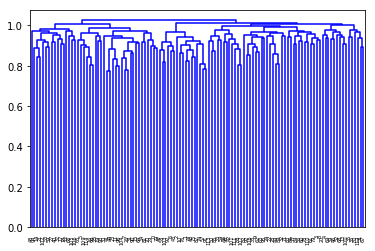

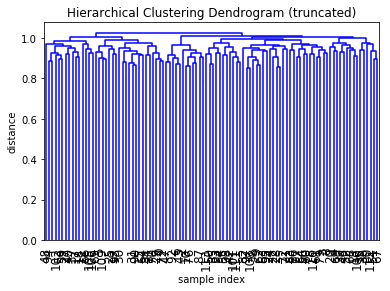

vmax=0.1745095237125909, vmin=-0.1745095237125909
(115, 115)


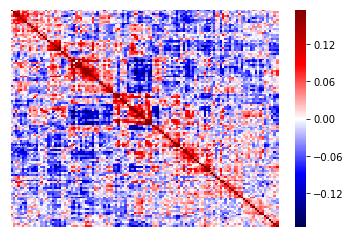

working on U118MG_CENTRAL_NERVOUS_SYSTEM, of shape (6142, 102)
(102, 102) 5151 (6142, 102) 5151.0


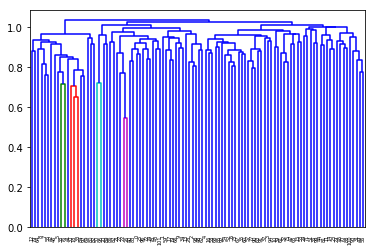

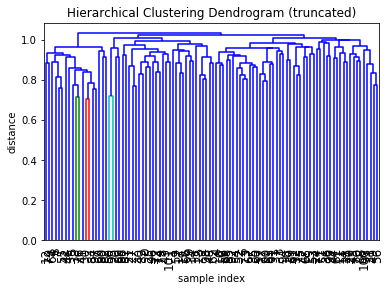

vmax=0.21239182335078394, vmin=-0.21239182335078394
(102, 102)


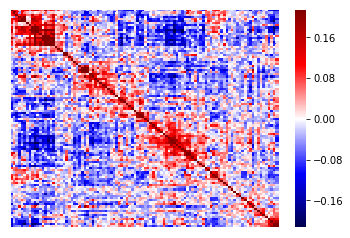

working on CAKI2_KIDNEY, of shape (5722, 138)
(138, 138) 9453 (5722, 138) 9453.0


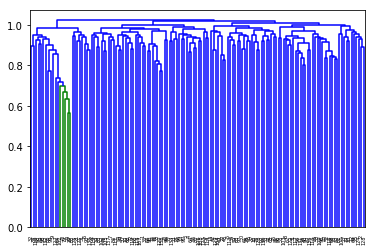

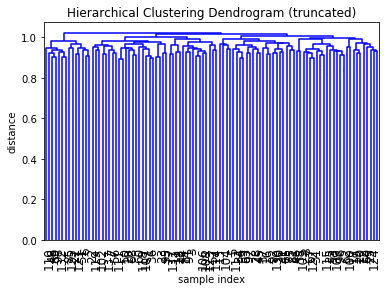

vmax=0.17522501320200812, vmin=-0.17522501320200812
(138, 138)


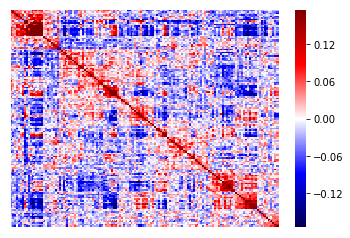

working on OVCAR4_OVARY, of shape (5936, 149)
(149, 149) 11026 (5936, 149) 11026.0


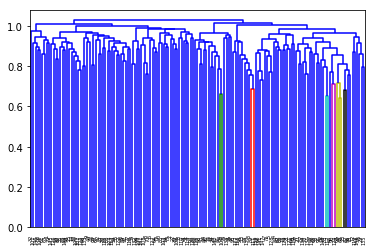

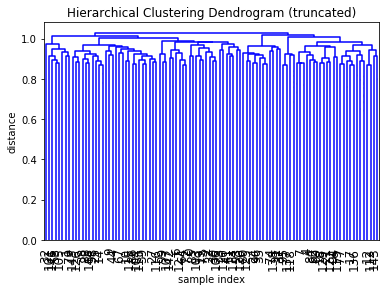

vmax=0.2131160316777871, vmin=-0.2131160316777871
(149, 149)


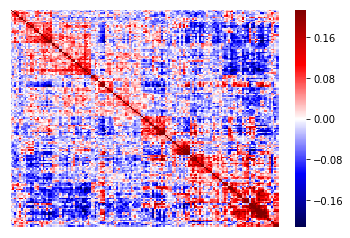

working on HUH28_BILIARY_TRACT, of shape (6315, 76)
(76, 76) 2850 (6315, 76) 2850.0


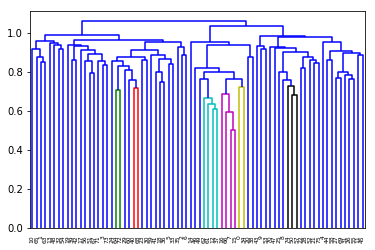

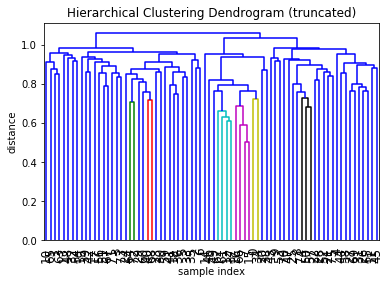

vmax=0.22666407975124764, vmin=-0.22666407975124764
(76, 76)


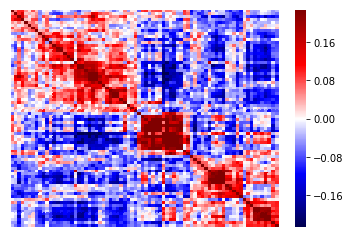

working on BICR16_UPPER_AERODIGESTIVE_TRACT, of shape (5581, 87)
(87, 87) 3741 (5581, 87) 3741.0


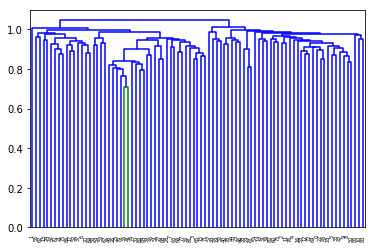

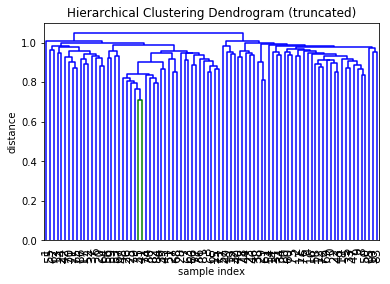

vmax=0.1731299908287204, vmin=-0.1731299908287204
(87, 87)


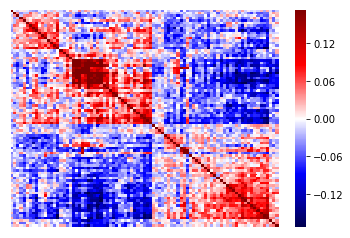

working on OAW28_OVARY, of shape (5927, 72)
(72, 72) 2556 (5927, 72) 2556.0


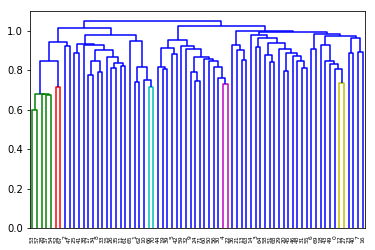

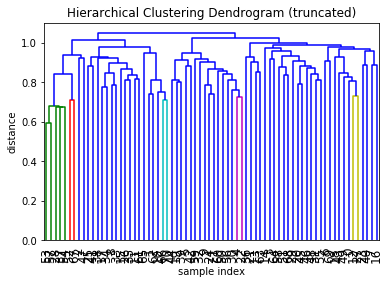

vmax=0.25990979433682987, vmin=-0.25990979433682987
(72, 72)


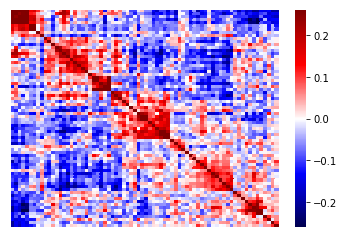

working on UACC257_SKIN, of shape (5901, 100)
(100, 100) 4950 (5901, 100) 4950.0


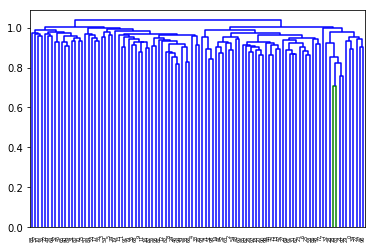

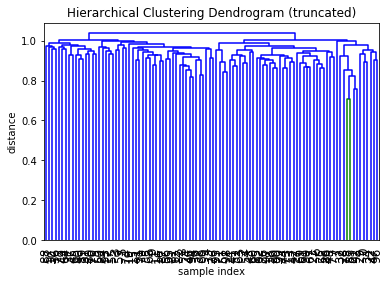

vmax=0.15619681584741635, vmin=-0.15619681584741635
(100, 100)


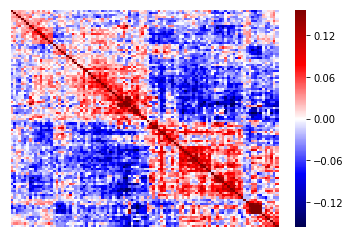

working on ONCODG1_OVARY, of shape (5110, 146)
(146, 146) 10585 (5110, 146) 10585.0


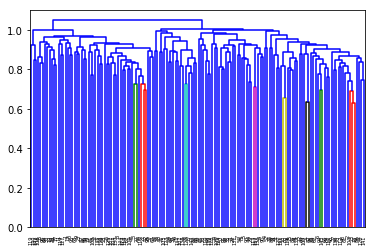

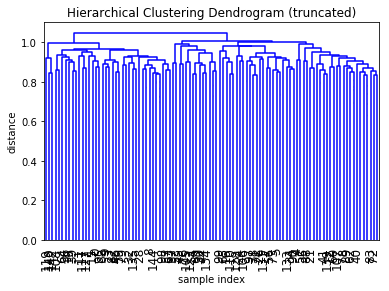

vmax=0.2421745817816209, vmin=-0.2421745817816209
(146, 146)


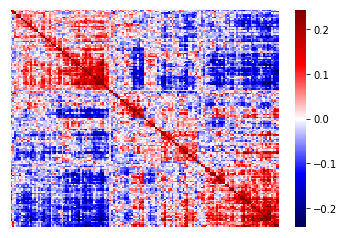

working on ASPC1_PANCREAS, of shape (5432, 97)
(97, 97) 4656 (5432, 97) 4656.0


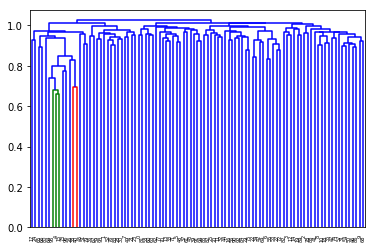

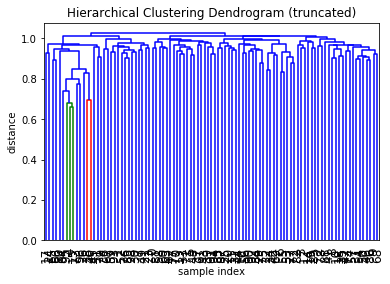

vmax=0.156626082751355, vmin=-0.156626082751355
(97, 97)


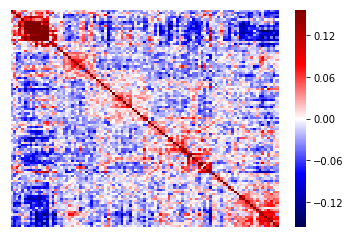

working on HEC6_ENDOMETRIUM, of shape (6443, 65)
(65, 65) 2080 (6443, 65) 2080.0


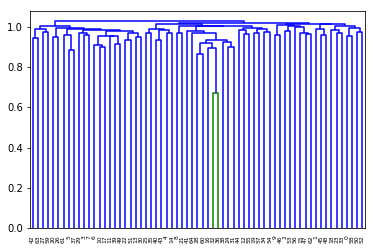

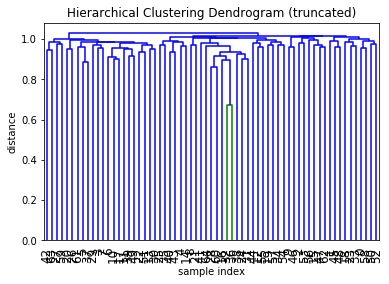

vmax=0.13635425443988214, vmin=-0.13635425443988214
(65, 65)


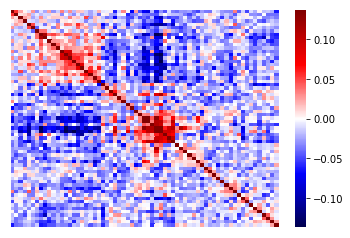

working on 8305C_THYROID, of shape (5841, 185)
(185, 185) 17020 (5841, 185) 17020.0


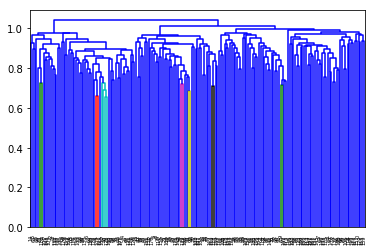

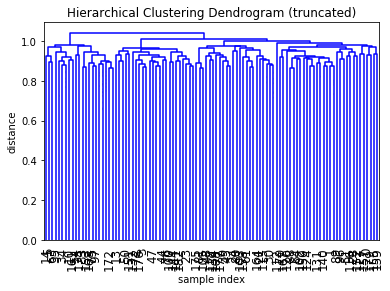

vmax=0.2066446195212491, vmin=-0.2066446195212491
(185, 185)


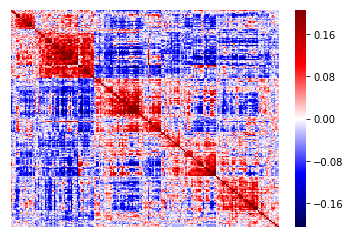

working on NCIH2444_LUNG, of shape (6227, 79)
(79, 79) 3081 (6227, 79) 3081.0


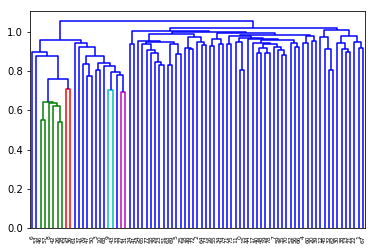

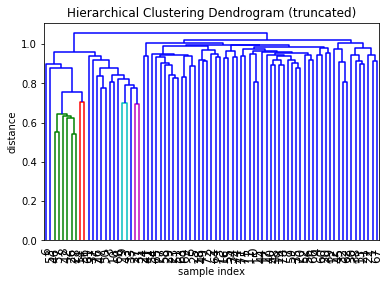

vmax=0.20879608514369938, vmin=-0.20879608514369938
(79, 79)


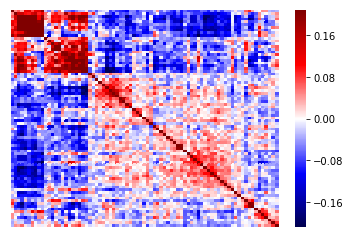

working on TE14_OESOPHAGUS, of shape (5327, 225)
(225, 225) 25200 (5327, 225) 25200.0


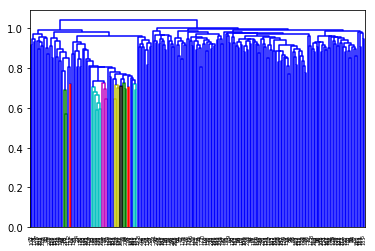

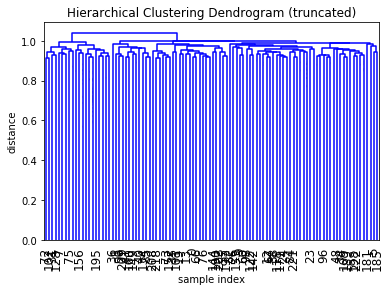

vmax=0.2085454155430601, vmin=-0.2085454155430601
(225, 225)


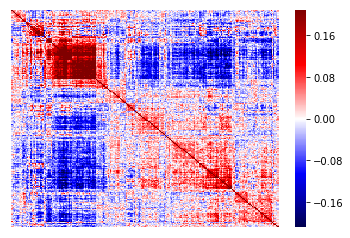

In [63]:
for cell_line, exp_matrix in centered_cell_lines_dict.items():
    print('working on {}, of shape {}'.format(cell_line, exp_matrix['exp_mat'].shape))
    corr_dist, tree, dn = create_clustering(exp_matrix['exp_mat'], show=True)
    centered_cell_lines_dict[cell_line]['corr_dist'] = corr_dist
    centered_cell_lines_dict[cell_line]['tree'] = tree
    centered_cell_lines_dict[cell_line]['dn'] = dn
    show_correlation_heatmap(exp_matrix['exp_mat'], dn)

# Cluster filtering

## Computer differential expression for each cluster in each cell line
For each gene we compute the t_test between cluster and non_cluster cells.
Meaningul clusters are of p-value lower than $10^{-4}$ or $10^{-5}$

In [64]:
def calculate_jaccard_sim_binary(a, b):
    return np.logical_and(a,b).sum() / float(np.logical_or(a, b).sum())

In [65]:
class Tree:
    def __init__(self, linkage_mat, exp_matrix, dend, bottom_threshold=5, top_threshold_percentage=80.0):
        self.linkage_matrix = linkage_mat
        self.exp_matrix = exp_matrix
        self.dn = dend
        self.num_original_elements = self.linkage_matrix.shape[0]+1
        self.children_dict = {}
        self.get_children_dict()
        self.bottom_threshold = bottom_threshold
        self.top_threshold_percentage = top_threshold_percentage
        self.top_threshold = int(math.ceil(self.top_threshold_percentage*self.num_original_elements/100.0))
        print("Using boundaries of {} and {}".format(self.bottom_threshold, self.top_threshold))
        self.filter_clusters_by_size()
    
    def get_children_dict(self):
        for i in range(self.num_original_elements):
            self.children_dict[i] = set([i])
        for i in range(self.linkage_matrix.shape[0]):
            child_1, child_2, _, num_elements = self.linkage_matrix[i]
            try:
                self.children_dict[i+self.num_original_elements] = self.children_dict[
                    int(child_1)].union(self.children_dict[int(child_2)])
                if not len(self.children_dict[i+self.num_original_elements])==num_elements:
                    print("wrong number of elements")
                    raise IOError
            except:
                print("failed at cluster #{}".format(i))
                print(i+1+self.num_original_elements)
                print(child_1)
    
    def filter_clusters_by_size(self):
        self.filtered_clusters = {}
        for clust_id, cluster in self.children_dict.items():
            if len(cluster)>=self.bottom_threshold and len(cluster)<=self.top_threshold:
                self.filtered_clusters[clust_id] = cluster
                
    def create_differential_expression_matrix(self, p_value_threshold=10**-4, fold_change_threshold=2):
        differential_expression_per_cluster = {}
        most_significant_gene_express = pd.DataFrame(
            index=self.exp_matrix.index)
        for clust_id, cluster in self.filtered_clusters.items():
        #     print(clust_id)
            in_clust = centered_cell_lines_dict[cell_line]['exp_mat'].iloc[:, list(cluster)]
            out_clust = centered_cell_lines_dict[cell_line]['exp_mat'].iloc[
                :, list(set(range(
                    centered_cell_lines_dict[cell_line]['exp_mat'].shape[1])) - cluster)]
            diff_exp_genes = pd.DataFrame(data = in_clust.index, columns=['gene_number'])
            diff_exp_genes['ttest_res'] = diff_exp_genes['gene_number'].apply(
                lambda x: scipy.stats.ttest_ind(in_clust.loc[x], out_clust.loc[x]))
            diff_exp_genes['t_statistic'] = diff_exp_genes.ttest_res.apply(lambda x: x[0])
            diff_exp_genes['p_value'] = diff_exp_genes.ttest_res.apply(lambda x: x[1])
            most_significant_gene_express[clust_id] = diff_exp_genes['p_value']
            diff_exp_genes['fold_change'] = diff_exp_genes['gene_number'].apply(
                lambda x: np.absolute(np.mean(in_clust.loc[x]) - np.mean(out_clust.loc[x])))
            diff_exp_genes['is_significant'] = diff_exp_genes.apply(
                lambda x: x['p_value']<=p_value_threshold and x['fold_change']>=fold_change_threshold, axis=1)
#             print("cluster {}, {} differentially expressed genes".format(
#                 clust_id,diff_exp_genes['is_significant'].sum()))
            differential_expression_per_cluster[clust_id] = diff_exp_genes
        self.most_significant_gene_express = most_significant_gene_express
        self.differential_expression_per_cluster = differential_expression_per_cluster
        self.most_significant_cluster_per_gene = self.most_significant_gene_express.apply(
            lambda x: x.idxmin(skipna=True), axis=1).dropna()
        
    def get_significant_clusters(self, min_significant_genes=30, min_most_significant_genes=5, **kwargs):
        if not hasattr(self, 'differential_expression_per_cluster'):
            self.create_differential_expression_matrix(**kwargs)
        significant_clusters = pd.DataFrame(index=['num_significant_genes', 'num_most_significant_genes'])
        for clust_id, cluster in self.filtered_clusters.items():
            try:
                num_significant_genes = self.differential_expression_per_cluster[clust_id]['is_significant'].sum()
            except:
                print('tmp.differential_expression_per_cluster {}, clust_id {}, res'.format(
                    self.differential_expression_per_cluster, clust_id, 
                    self.differential_expression_per_cluster[clust_id]['is_significant'].sum()))
                raise
            num_most_significant_genes = sum(self.most_significant_cluster_per_gene==clust_id)
            if num_significant_genes>=min_significant_genes or \
            num_most_significant_genes>=min_most_significant_genes:
                significant_clusters[clust_id] = [num_significant_genes, num_most_significant_genes]
        print(significant_clusters.shape)
        significant_clusters = significant_clusters.transpose()
        significant_clusters = significant_clusters.reset_index().rename(
            columns={'index':'cluster_id'}).set_index('cluster_id')
        significant_clusters.sort_values(
            by=['num_significant_genes', 'num_most_significant_genes'], 
            inplace=True, ascending=False)
        self.significant_clusters = significant_clusters
        
    def visualize_meaningful_clusters(self, **kwargs):
        if not hasattr(self, 'significant_clusters'):
            self.get_significant_clusters(**kwargs)
        cells_vs_clusters = pd.DataFrame(data = np.array(
            [False]*self.num_original_elements*self.significant_clusters.shape[0]).reshape(
            self.significant_clusters.shape[0], self.num_original_elements),
            index=self.significant_clusters.index, 
            columns=range(self.num_original_elements))
        for cluster_id in self.significant_clusters.index:
            cells_vs_clusters.loc[cluster_id].iloc[list(self.children_dict[cluster_id])] = True
        cells_vs_clusters = cells_vs_clusters.iloc[:, centered_cell_lines_dict[cell_line]['dn']['leaves']]
        cm = matplotlib.colors.LinearSegmentedColormap.from_list('BinaryColormap', ['black', 'yellow'], N=2)
        self.cm = cm
        fig, ax = plt.subplots(2, 1, figsize=(8, 16))

        corr_matrix = np.corrcoef(
            self.exp_matrix.iloc[
                :, self.dn['leaves']].transpose())
        mask = corr_matrix==1
        sns.heatmap(
            corr_matrix, 
            xticklabels=False, 
            yticklabels=False,
            cmap='seismic', 
            vmax=0.3, 
            vmin=-0.3, 
            ax=ax[0])
        print("significant shape matrix {}".format(cells_vs_clusters.shape))
        sns.heatmap(cells_vs_clusters, cmap=cm, ax=ax[1], linewidths=0.01)
        ax[1].set_xlabel('Cells')
        ax[1].get_xaxis().set_ticks(range(cells_vs_clusters.shape[1]))
        ax[1].get_yaxis().set_ticks(range(cells_vs_clusters.shape[0]))
        ax[1].tick_params(labelbottom=False, labelleft=False)
        self.cells_vs_clusters = cells_vs_clusters
        
    def compute_intersection_between_clusters(self, maximal_interaction=0.85):
        intersections_between_clusters = pd.DataFrame(
            index=self.cells_vs_clusters.index, 
            columns=self.cells_vs_clusters.index)
        for row in intersections_between_clusters.index.values:
            for col in intersections_between_clusters.columns.values:
                intersections_between_clusters.loc[row, col] = calculate_jaccard_sim_binary(
                    self.cells_vs_clusters.loc[row], self.cells_vs_clusters.loc[col])
        intersections_between_clusters -= np.identity(intersections_between_clusters.shape[0])
        clusters_to_keep = set(intersections_between_clusters.index)
        print(len(clusters_to_keep))
        while len(np.where(intersections_between_clusters>maximal_interaction)[0])>0:
            clust_1 = intersections_between_clusters.index[np.where(intersections_between_clusters>0.85)[0][0]]
            clust_2 = intersections_between_clusters.index[np.where(intersections_between_clusters>0.85)[1][0]]
            print(clust_1, clust_2)
            if self.significant_clusters.loc[
                clust_1].num_significant_genes > self.significant_clusters.loc[clust_2].num_significant_genes:
                intersections_between_clusters.drop(labels=[clust_2], axis=0, inplace=True)
                intersections_between_clusters.drop(labels=[clust_2], axis=1, inplace=True)
            elif self.significant_clusters.loc[
                clust_1].num_significant_genes < self.significant_clusters.loc[clust_2].num_significant_genes:
                intersections_between_clusters.drop(labels=[clust_1], axis=0, inplace=True)
                intersections_between_clusters.drop(labels=[clust_1], axis=1, inplace=True)
            else:
                if self.significant_clusters.loc[
                    clust_1].num_most_significant_genes > self.significant_clusters.loc[
                    clust_2].num_most_significant_genes:
                    intersections_between_clusters.drop(labels=[clust_2], axis=0, inplace=True)
                    intersections_between_clusters.drop(labels=[clust_2], axis=1, inplace=True)
                else:
                    print("clusters {} and {} are weirdly similar".format(clust_1, clust_2))
                    intersections_between_clusters.drop(labels=[clust_1], axis=0, inplace=True)
                    intersections_between_clusters.drop(labels=[clust_1], axis=1, inplace=True)
        self.intersections_between_clusters = intersections_between_clusters
        fig, ax = plt.subplots(2, 1, figsize=(8, 10))

        corr_matrix = np.corrcoef(
            self.exp_matrix.iloc[
                :, self.dn['leaves']].transpose())
        mask = corr_matrix==1
        sns.heatmap(
            corr_matrix, 
            xticklabels=False, 
            yticklabels=False,
            cmap='seismic', 
            vmax=0.5, 
            vmin=-0.5, 
            ax=ax[0])
        print('intersection shape matrix {}'.format(
            self.cells_vs_clusters.loc[self.intersections_between_clusters.index].shape))
        sns.heatmap(
            self.cells_vs_clusters.loc[self.intersections_between_clusters.index], 
            cmap=self.cm, ax=ax[1], linewidths=0.01)
        ax[1].set_xlabel('Cells')
        ax[1].get_xaxis().set_ticks(range(self.cells_vs_clusters.shape[1]))
        ax[1].get_yaxis().set_ticks(range(self.intersections_between_clusters.shape[0]))
        ax[1].tick_params(labelbottom=False, labelleft=False)

        plt.tight_layout()
        plt.show()

Using boundaries of 5 and 92
(2, 1)
significant shape matrix (1, 115)
1
intersection shape matrix (1, 115)


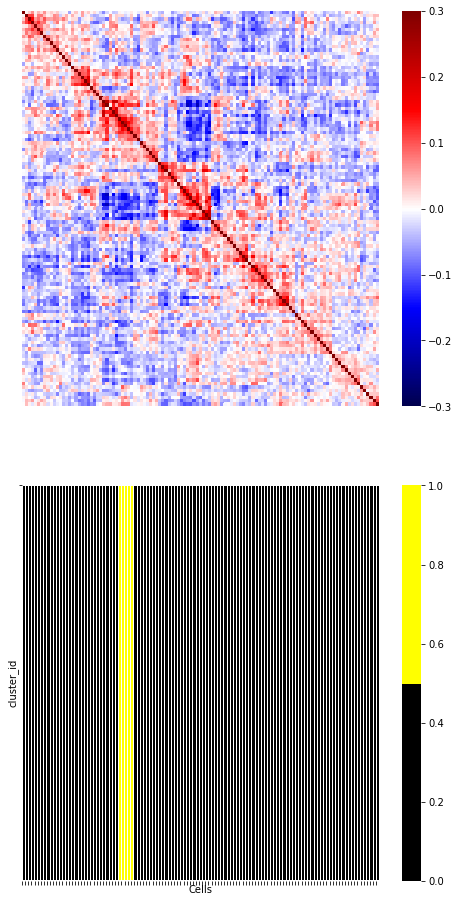

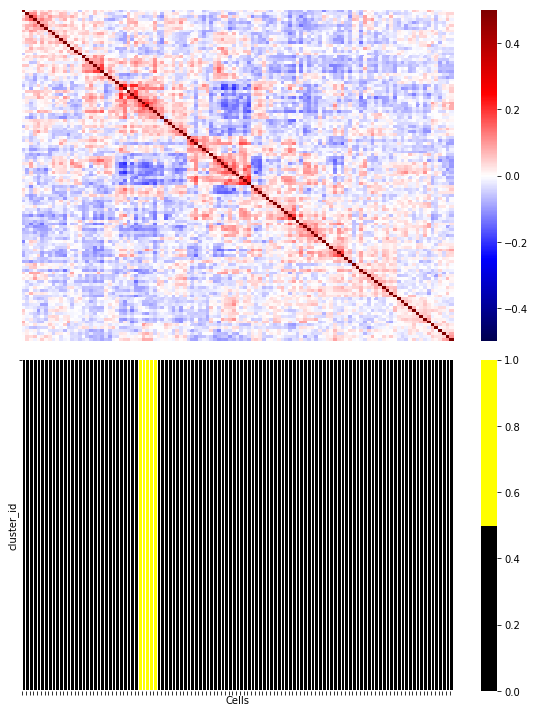

In [66]:
cell_line = 'KALS1_CENTRAL_NERVOUS_SYSTEM'
tmp = Tree(centered_cell_lines_dict[cell_line]['tree'], 
           centered_cell_lines_dict[cell_line]['exp_mat'],
           centered_cell_lines_dict[cell_line]['dn'])
tmp.visualize_meaningful_clusters()
tmp.compute_intersection_between_clusters()

working on cell line SNU46_UPPER_AERODIGESTIVE_TRACT
Using boundaries of 5 and 100
(2, 12)
significant shape matrix (12, 125)
12
151 149
165 169
170 190
228 201
intersection shape matrix (8, 125)


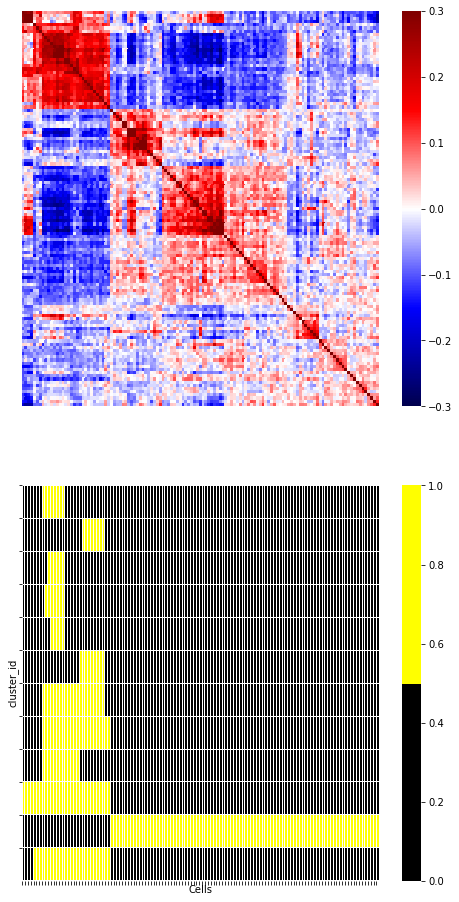

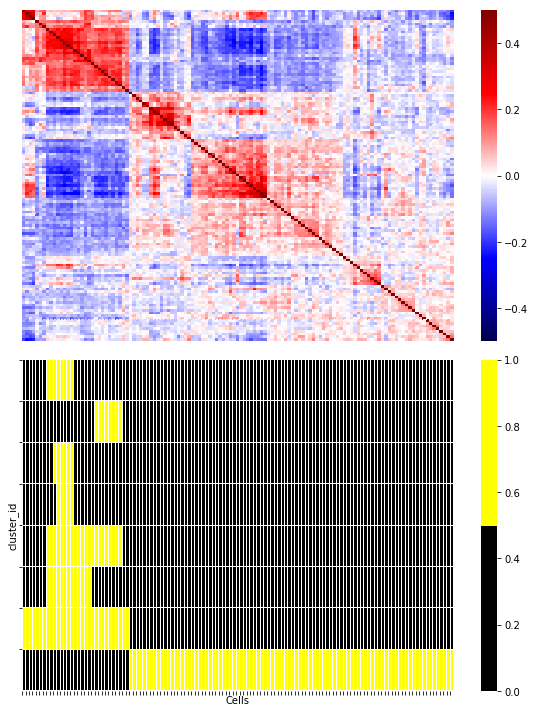

working on cell line NCIH2228_LUNG
Using boundaries of 5 and 104
(2, 6)
significant shape matrix (6, 130)
6
232 240
intersection shape matrix (5, 130)


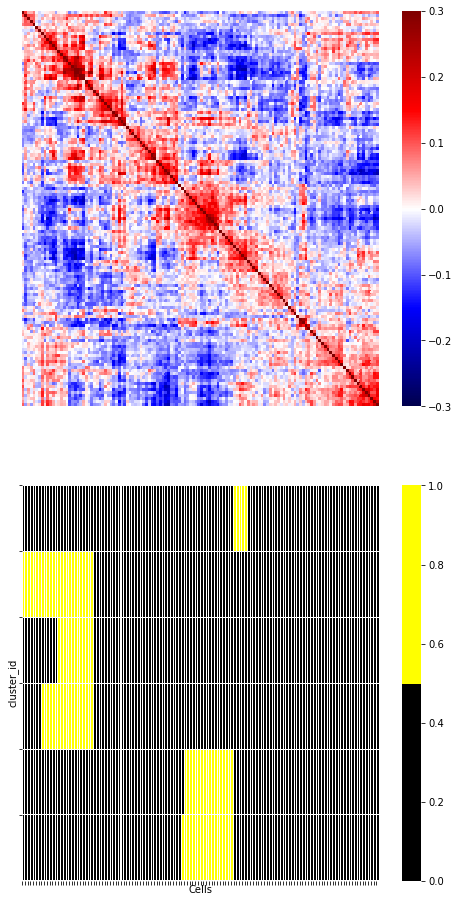

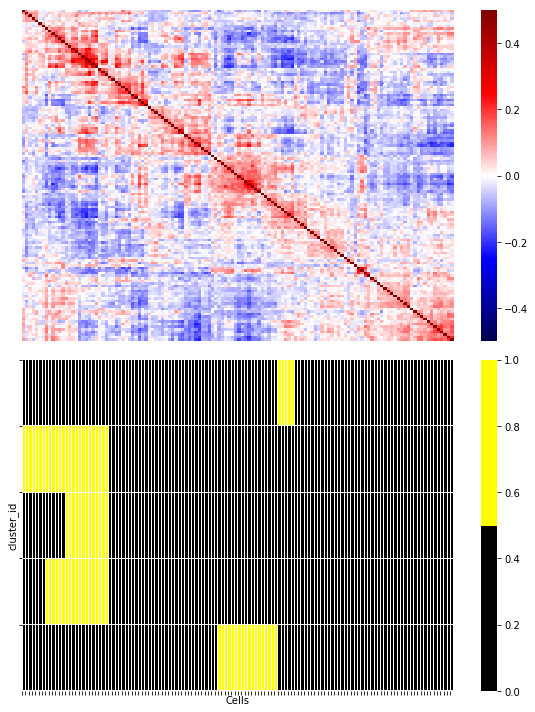

working on cell line SKMEL5_SKIN
Using boundaries of 5 and 83
(2, 10)
significant shape matrix (10, 103)
10
108 112
115 126
115 174
146 157
intersection shape matrix (6, 103)


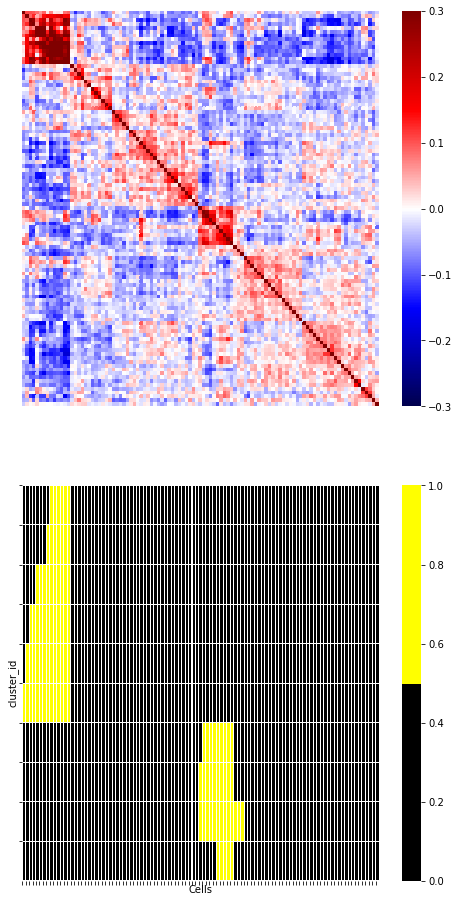

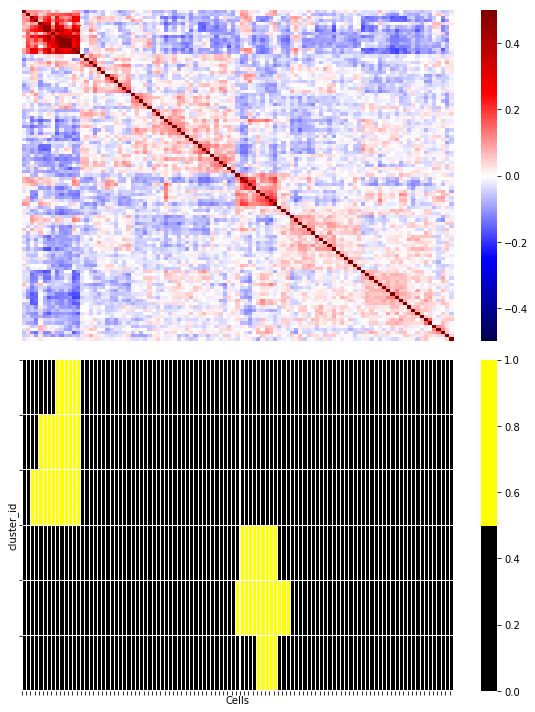

working on cell line SCC25_UPPER_AERODIGESTIVE_TRACT
Using boundaries of 5 and 71
(2, 6)
significant shape matrix (6, 88)
6
110 127
intersection shape matrix (5, 88)


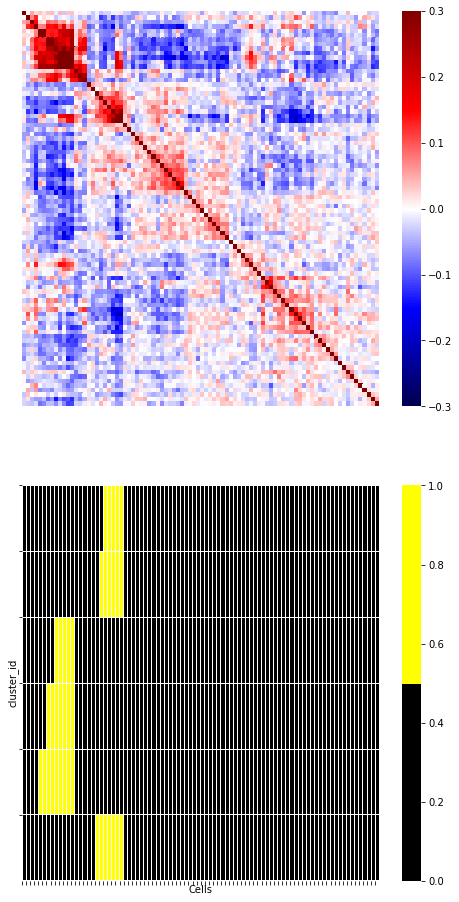

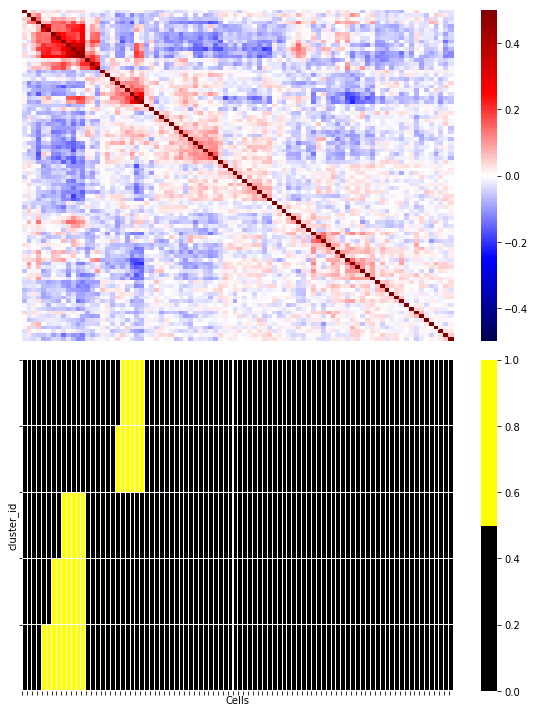

working on cell line KALS1_CENTRAL_NERVOUS_SYSTEM
Using boundaries of 5 and 92
(2, 1)
significant shape matrix (1, 115)
1
intersection shape matrix (1, 115)


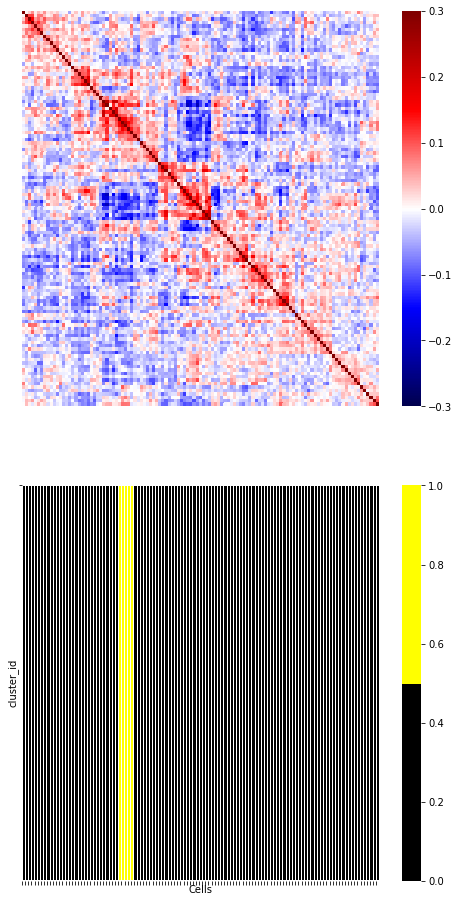

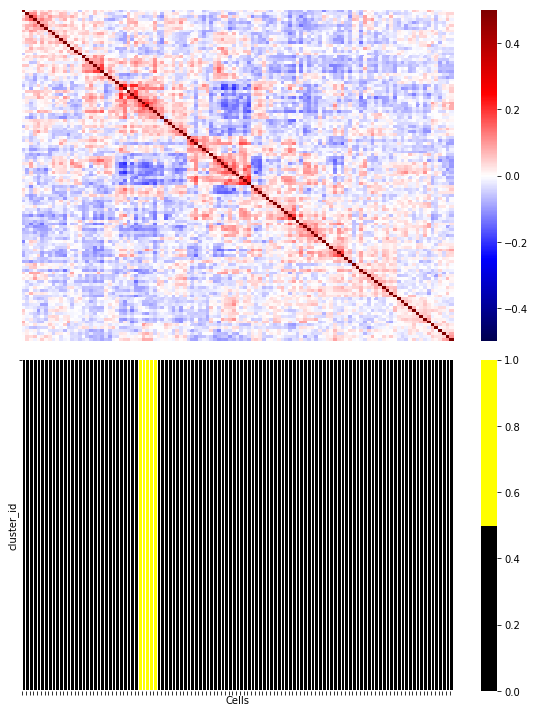

working on cell line U118MG_CENTRAL_NERVOUS_SYSTEM
Using boundaries of 5 and 82


KeyboardInterrupt: 

In [67]:
trees_per_cell_line = {}
for cell_line, cell_line_dict in centered_cell_lines_dict.items():
    print("working on cell line {}".format(cell_line))
    ret = Tree(cell_line_dict['tree'], 
               cell_line_dict['exp_mat'],
               cell_line_dict['dn'])
    ret.visualize_meaningful_clusters()
    ret.compute_intersection_between_clusters()
    trees_per_cell_line[cell_line] = ret

<font color=red>sort clusters by score</font>

1. Move from working on single cell line to compare between cell lines. Search programs that repeat between cell lines. Join programs from different cell lines, combine them to metaprograms.
For each program we defined it for a different set of cells. We need to move to differentially expressed genes.
Two options:
1. For each program take the 50 top genes per program that are most significantly differentially expressed. Make sure that most significant genes enter these 50 top genes. If not replace them with the last genes. 
Now we want to compare programs by either jaccard index or size of intersection. 
Add a figure below of from which cell line each program arrived to make sure we do not get clusters by cell lines. 

# From clusters to programs
We are moving our work now from per-cell to per-program (where a program is defined by a cluster).
This requires the following steps:
1. Convert clusters to programs. In order to do this we are going to look at the 50 top differentially expressed genes within a cluster. These will define the program of a cluster. When looking at said 50 top genes, we need to ensure that all most significant genes that are most differentially expressed in the cluster are in the cluster's program. If not then we will add them and remove the genes with the lowest differential expression that are not "most significantly expressed". 
2. We now have all significant clusters from all cell lines, and their programs defined by sets of 50 genes. We now work on defining a distance metric between different programs. To do this we could use the Jaccard index, however, since the size of the union of two programs is at most 100, and decreases when programs are closely related, we are going to use the size of the intersection as the similarity matrix. 
3. Once we have the different programs and their similarity matrix we will cluster them to get a new order of programs. We will show this in a heatmap and below it we will show a heatmp like (use ticks) showing which cell line each program came from. This to ensure we do not end up with clusters that are only based on original cell line of a program.
4. We might want to understand what programs are nearest to our new clusters - thie could be done using http://www.enrichnet.org/ (there is an a web version as well as an API we could try and use).

## Convert clusters to programs

In [ ]:
cell_line = 'TE14_OESOPHAGUS'
trees_per_cell_line[cell_line].differential_expression_per_cluster.keys()

In [ ]:
cp_diff = trees_per_cell_line[cell_line].differential_expression_per_cluster[231].sort_values(
    by='p_value', 
    ascending=True).copy()
cp_diff['defines_program'] = np.append([True]*50, [False]*(cp_diff.shape[0]-50))
cp_diff = cp_diff.pivot(index='cluster_id', columns='gene_number', values='defines_program')
cp_diff['cluster_id'] = 231

cp_diff2 = trees_per_cell_line[cell_line].differential_expression_per_cluster[246].sort_values(
    by='p_value',
    ascending=True).copy()
cp_diff2['cluster_id'] = 246
cp_diff2['defines_program'] = np.append([True]*50, [False]*(cp_diff2.shape[0]-50))
cp_diff2 = cp_diff2.pivot(index='cluster_id', columns='gene_number', values='defines_program')
cp_diff2['cluster_id'] = 246
pd.merge(cp_diff, cp_diff2, how='outer').set_index('cluster_id')

In [ ]:
number_of_genes_per_program = 50
significant_genes_df = []
for cell_line in trees_per_cell_line.keys():
    tmp_dict = []
    for clust_id in trees_per_cell_line[cell_line].differential_expression_per_cluster.keys():
        tmp_df = trees_per_cell_line[cell_line].differential_expression_per_cluster[clust_id].copy()
        tmp_df.sort_values(by='p_value', ascending=True)
        tmp_df['cluster_id'] = clust_id
        tmp_df['defines_program'] = np.append([True]*number_of_genes_per_program, 
                                              [False]*(tmp_df.shape[0]-number_of_genes_per_program))
        tmp_df = tmp_df.pivot(index='cluster_id', columns='gene_number', values='defines_program')
        tmp_df.columns = map(str, tmp_df.columns)
        tmp_df['cluster_id'] = clust_id
        tmp_dict.append(tmp_df)
    tmp_dict = pd.concat(tmp_dict, join='outer', ignore_index=True)
    tmp_dict['cell_line'] = cell_line
    print('cell line {}, tmp_dict shape {}, number of clusters {}'.format(
        cell_line, 
        tmp_dict.shape, 
        len(trees_per_cell_line[cell_line].differential_expression_per_cluster.keys())))
    significant_genes_df.append(tmp_dict)
print('finished working on cell lines')
significant_genes_df = pd.concat(significant_genes_df, join='outer', ignore_index=True)
significant_genes_df.set_index(keys=['cluster_id', 'cell_line'], inplace=True)
significant_genes_df.replace(np.nan, False, inplace=True)
print(significant_genes_df.shape)
significant_genes_df.head()

In [ ]:
program_distmat = significant_genes_df.apply(
    lambda x: significant_genes_df.apply(
        lambda y:sum(np.logical_and(x, y))/100, axis=1), axis=1)
sns.heatmap(program_distmat, cmap='seismic')

In [ ]:
program_corr_tree = linkage(program_distmat, method='average')
program_dn = dendrogram(program_corr_tree)
program_distmat_sorted = program_distmat.iloc[program_dn['leaves'], program_dn['leaves']]

In [ ]:
original_cell_line = pd.DataFrame(columns=list(program_distmat_sorted.index.get_level_values(1).unique().sort_values()), 
             index=program_distmat_sorted.columns,
             data=np.array(list(map(lambda x: np.array(list(
                 program_distmat_sorted.index.get_level_values(1).unique().sort_values()))==x,
                                    program_distmat_sorted.columns.get_level_values(1).values)))).transpose()

In [ ]:
my_rwb = matplotlib.colors.LinearSegmentedColormap.from_list('my_rwb', [(1,0,0), (1,1,1), (0,0,1)], 1000)
fig, ax = plt.subplots(2, 1, figsize=(8,10))
sns.heatmap(program_distmat_sorted,
            xticklabels=False, 
            yticklabels=False, 
            cmap=my_rwb,
            ax=ax[0])
sns.heatmap(original_cell_line, xticklabels=False, ax=ax[1])

## Meeting with Itay 25/04/2018
TODO list:
1. Change differentially expressed definition to have only genes that have higher expression
2. Issue with separation to cell line (might be cause due to selection of genes) check this
3. Turn pipeline into universal with wrapper